A notebook to examine how modifications to the bathymetry have affected the baroclinic tides.

# Background

Three cases are considered

1. Original bathymetry (bathy2)
2. Extended river (bathy6)
3. Extended river and no banks (bathy9)
4. Jetty (bathy10)

Simulations were started from rest on April 21, 2003 the "same" stratification taken from April in the spin-up year. In cases 2 and 3, the spin-up stratification was interpolated to fill in new depth points. 

The first 10 days of each simulation were neglected in the tidal analysis. 

The simulations were forced with CGRF winds. rn_avt0=1e-5, rn_avm0=1e-5


In [1]:
import datetime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio

from salishsea_tools import viz_tools
from salishsea_tools import ellipse
from salishsea_tools.nowcast import research_VENUS

import baroclinic as bc
%matplotlib inline

# Model fields

Take a quick peak at the surface salinty and currents at a few snapshtos in time.

In [3]:
SITES = research_VENUS.SITES['VENUS']
runs = ['bathy2', 'bathy6', 'bathy9', 'bathy10']
bathys = {}
for run in runs:
    bathys[run] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea{}.nc'.format(run[5:]))
lons = {}
lats = {}
sals = {}
us={}
vs={}
times = {}
depths = {}


init_time = datetime.datetime(2003,4,21)

base = '/data/nsoontie/MEOPAR/SalishSea/results/tides/bathymods/'

for run in runs:
    f = nc.Dataset(os.path.join(base, run, 'CODAR_all.nc'))
    sals[run] = f.variables['vosaline'][:]
    U = f.variables['vozocrtx'][:]
    V = f.variables['vomecrty'][:]
    us[run], vs[run] = ellipse.prepare_vel(U,V)
    lons[run] = f.variables['nav_lon'][:]
    lats[run] = f.variables['nav_lat'][:]
    depths[run] = f.variables['deptht'][:]
    times[run] = [ init_time + datetime.timedelta(seconds = f.variables['time_counter'][t])
                  for t in np.arange(sals[run].shape[0])]

In [7]:
def plot_salinity_quiver(time, depth, vmin=0,vmax=34, st=5, sc=8):
    """Plot salinity and velocity quivers of each simulaiton in a different panel
    time, depth define the time stamp and depth level"""

    fig, axs = plt.subplots(1,4,figsize=(20,5)) 

    for run, ax in zip(runs, axs):
        #mask and plot
        salP=sals[run][time, depth,:,:]
        salP=np.ma.masked_values(salP, 0)
        mesh = ax.pcolormesh(lons[run], lats[run], salP, vmin=vmin, vmax=vmax,cmap='spectral')
        #Add bathymetry contours
        viz_tools.plot_coastline(ax, bathys[run], coords='map')
        viz_tools.plot_coastline(ax, bathys[run], coords='map', isobath=5, color='black')
        viz_tools.plot_coastline(ax, bathys[run], coords='map', isobath=20, color='black')
        
        #Add quiver
        lon = lons[run][1:,1:]
        lat = lats[run][1:,1:]
        quiver = ax.quiver(lon[::st,::st], lat[::st,::st], us[run][time,depth,::st,::st], 
                           vs[run][time ,depth,::st,::st],
                           pivot='mid', width=0.003,scale=sc, color='dimgrey', 
                           headwidth=10, headlength=5
                           )
        ax.quiverkey(quiver,-123.6,48.81, 1, '1 m/s',
                 coordinates='data', color='black', labelcolor='black')
    
    
        #Add labels etc
        cbar = plt.colorbar(mesh, ax=ax)
        cbar.set_label('Salinity [psu]')
        ax.set_title('{0} \n {1} Depth {2:.3g} m'.format(run, times[run][time], depths[run][depth]))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
    
        #Axis limits
        ax.set_xlim([-123.7,-123])
        ax.set_ylim([48.8,49.3])
        
    return fig

Initial time

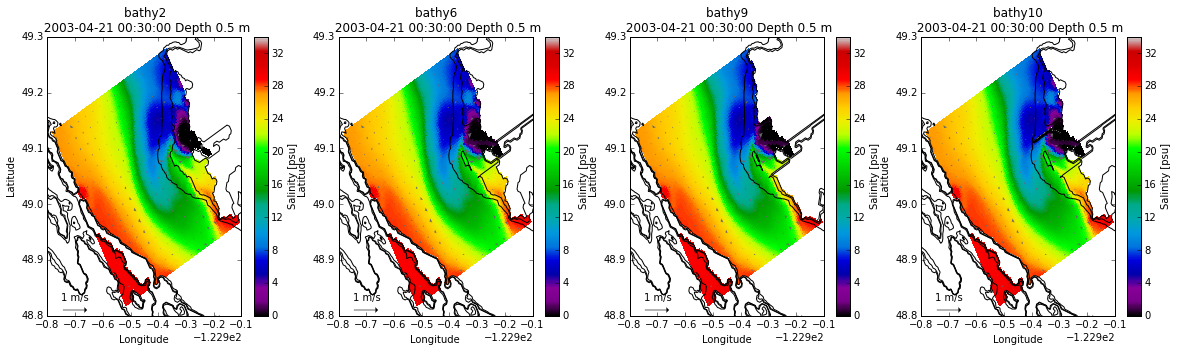

In [8]:
time= 0
depth=0
fig =plot_salinity_quiver(time, depth)

During adjustment (5 days)

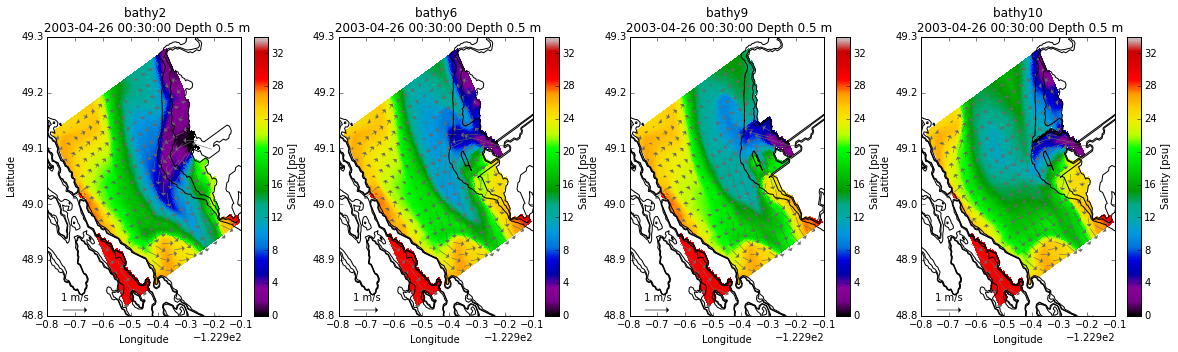

In [9]:
time= 120
depth=0
fig =plot_salinity_quiver(time, depth)

After adjustment ( 20 days)

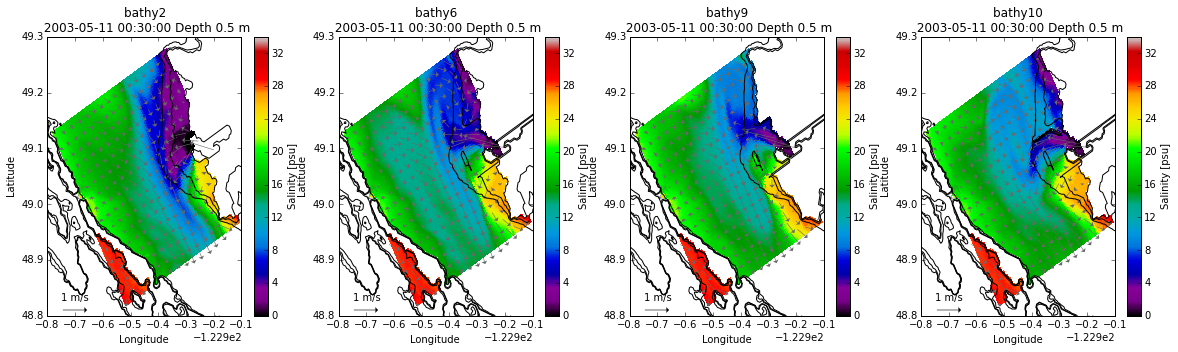

In [10]:
time= 480
depth=0
fig =plot_salinity_quiver(time, depth)

Final time (40 days)

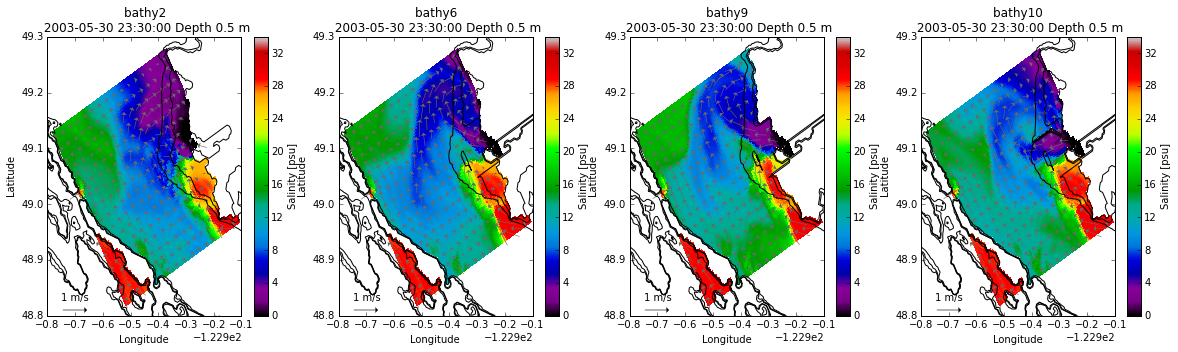

In [34]:
time= -1
depth=0
fig =plot_salinity_quiver(time, depth)

Do these have the same amount of fresh water coming into the domain?  The source is in a very different location in bathy6/9, so maybe it is just the time to propagate along the river?

Also, is it possible that the other arms of the Fraser have been removed in bathy9? Check with Jie

I used the monthly rivers file in bathy2. And then I used the monthly flag when constructing the river dishcarge using Jie's/Kate's/Susan's methodology.

# Tides

Now look at the tidal analysis for each case.

M2 major at surface baroclinic

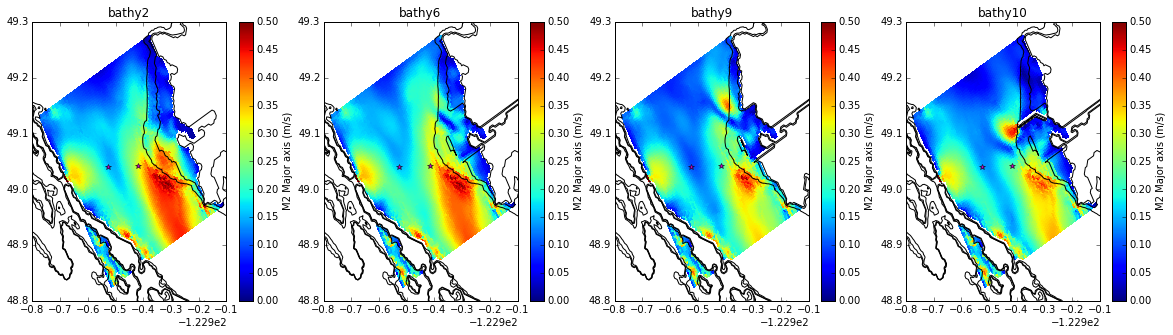

In [37]:
const='M2'
fig, axs = plt.subplots(1,4,figsize=((20,5)))
for run, ax in zip(runs, axs):
    data =sio.loadmat(
        '/data/nsoontie/MEOPAR/SalishSea/results/tides/bathymods/{}/baroclinic_tides_masked.mat'.format(run))
    datastruc = data['datastruc']
    lats = datastruc['lats'][0,0]
    lons = datastruc['lons'][0,0]
    
    major, minor, phase, incli= bc.get_constituent(const ,datastruc)
    mesh=ax.pcolormesh(lons, lats, major[:,:,0], vmin=0,vmax=0.5)
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('M2 Major axis (m/s)')
    
    ax.set_title(run)
    #Add bathymetry contours
    viz_tools.plot_coastline(ax, bathys[run], coords='map')
    viz_tools.plot_coastline(ax, bathys[run], coords='map', isobath=5, color='black')
    viz_tools.plot_coastline(ax, bathys[run], coords='map', isobath=20, color='black')
    ax.plot(SITES['Central']['lon'], SITES['Central']['lat'], 'm*', label='Central')
    ax.plot(SITES['East']['lon'], SITES['East']['lat'], 'm*',label = 'East')
    
    #Axis limits
    ax.set_xlim([-123.7,-123])
    ax.set_ylim([48.8,49.3])


M2 Ellipses and vectors at high water at Point Atkinson

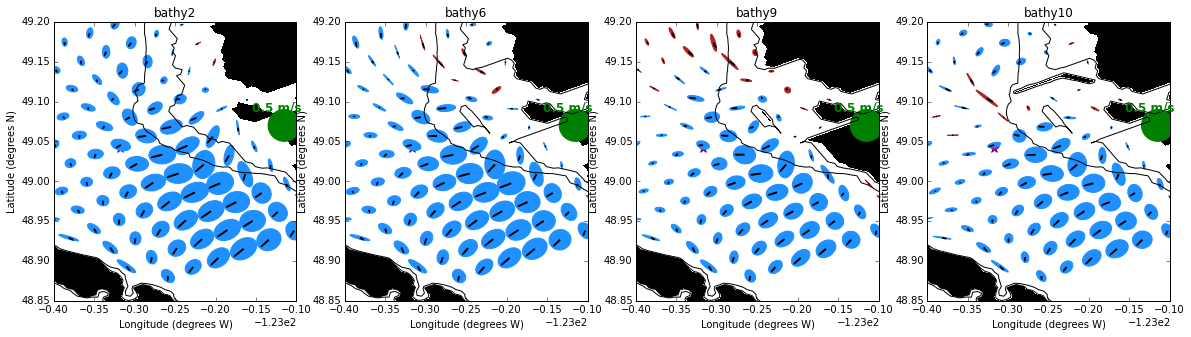

In [40]:
const='M2'
sc_ell=0.08
st=6
sc_quiv = 8
time_deg = 31 #M2 phase of elevation at Point Atkinson
fig, axs = plt.subplots(1,4,figsize=((20,5)))
for run, ax in zip(runs, axs):
    data =sio.loadmat(
        '/data/nsoontie/MEOPAR/SalishSea/results/tides/bathymods/{}/baroclinic_tides_masked.mat'.format(run))
    datastruc = data['datastruc']
    lats = datastruc['lats'][0,0]
    lons = datastruc['lons'][0,0]
    depths = datastruc['depth'][0,0]
    
    grid = bathys[run]
    
    bc.plot_CODAR_ellipse(ax,lons, lats, const, datastruc,depths, grid, scale=sc_ell, step=st,
                          baroclinic=True, depth_level=0)
    bc.plot_ellipse_phase_arrow(ax, lons, lats, const, datastruc, time_deg, scale=sc_quiv, step=st, baroclinic=True)
    ax.set_title(run)
    ax.plot(SITES['Central']['lon'], SITES['Central']['lat'], 'm*', label='Central',ms=10,zorder=1)
    ax.plot(SITES['East']['lon'], SITES['East']['lat'], 'm*',label = 'East',ms=10,zorder=1)
    
    #Axis limits
    ax.set_xlim([-123.4,-123.1])
    ax.set_ylim([48.85,49.2])
    bc.add_scale_ellipse(ax, -123.115,49.07, dx=-.04, dy=0.018,scale = sc_ell)

Maybe better to look at the phase of the east/west velocity. Or look at the barotropic current instead?

## Barotropic

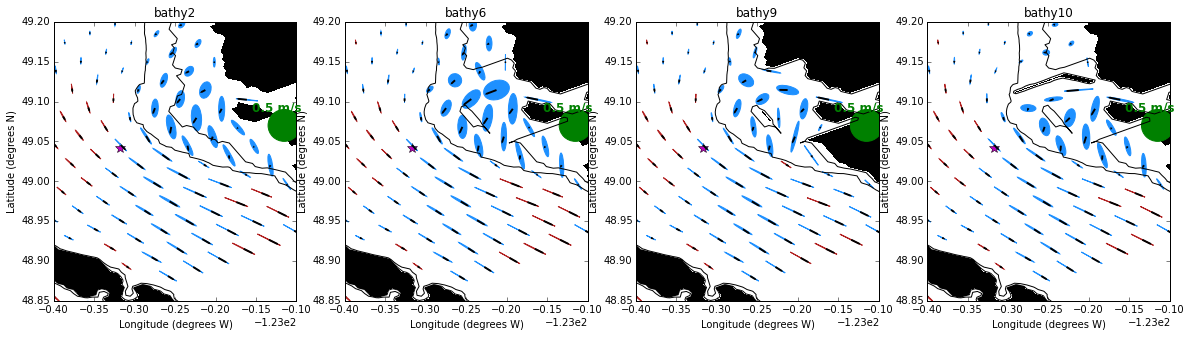

In [43]:
const='M2'
sc_ell=0.08
st=6
sc_quiv = 8
time_deg = 31 #M2 phase of elevation at Point Atkinson
fig, axs = plt.subplots(1,4,figsize=((20,5)))
for run, ax in zip(runs, axs):
    data =sio.loadmat(
        '/data/nsoontie/MEOPAR/SalishSea/results/tides/bathymods/{}/barotropic_tides_masked.mat'.format(run))
    datastruc = data['datastruc']
    lats = datastruc['lats'][0,0]
    lons = datastruc['lons'][0,0]
    depths = datastruc['depth'][0,0]
    
    grid = bathys[run]
    
    bc.plot_CODAR_ellipse(ax,lons, lats, const, datastruc,depths, grid, scale=sc_ell, step=st,
                          barotropic=True, depth_level=0)
    bc.plot_ellipse_phase_arrow(ax, lons, lats, const, datastruc, time_deg, scale=sc_quiv, step=st, baroclinic=False)
    ax.set_title(run)
    ax.plot(SITES['Central']['lon'], SITES['Central']['lat'], 'm*', label='Central',ms=10,zorder=1)
    ax.plot(SITES['East']['lon'], SITES['East']['lat'], 'm*',label = 'East',ms=10,zorder=1)
    
    #Axis limits
    ax.set_xlim([-123.4,-123.1])
    ax.set_ylim([48.85,49.2])
    bc.add_scale_ellipse(ax, -123.115,49.07, dx=-.04, dy=0.018,scale = sc_ell)

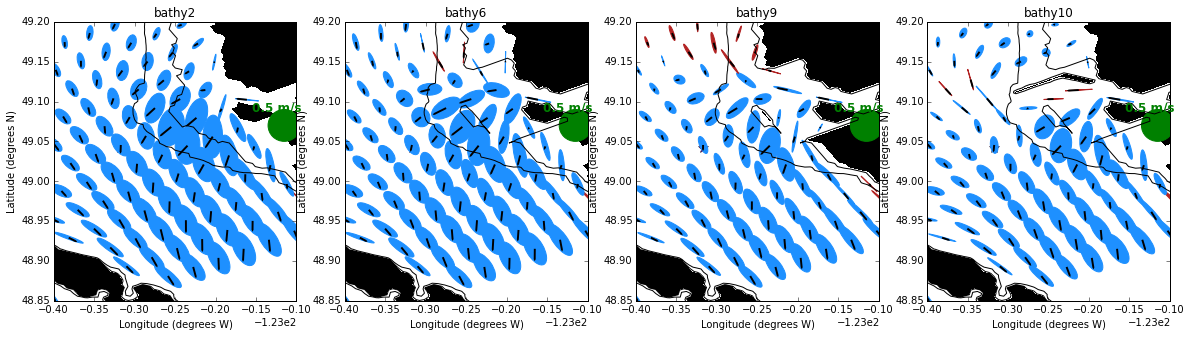

In [46]:
const='M2'
sc_ell=0.08
st=6
sc_quiv = 8
time_deg = 31 #M2 phase of elevation at Point Atkinson
fig, axs = plt.subplots(1,4,figsize=((20,5)))
for run, ax in zip(runs, axs):
    data =sio.loadmat(
        '/data/nsoontie/MEOPAR/SalishSea/results/tides/bathymods/{}/surface_tides.mat'.format(run))
    datastruc = data['datastruc']
    lats = datastruc['lats'][0,0]
    lons = datastruc['lons'][0,0]
    
    grid = bathys[run]
    
    bc.plot_CODAR_ellipse(ax,lons, lats, const, datastruc,depths, grid, scale=sc_ell, step=st,
                          baroclinic=False, barotropic=False, depth_level=0)
    bc.plot_ellipse_phase_arrow(ax, lons, lats, const, datastruc, time_deg, scale=sc_quiv, step=st, baroclinic=False)
    ax.set_title(run)
    ax.plot(SITES['Central']['lon'], SITES['Central']['lat'], 'm*', label='Central',ms=10,zorder=1)
    ax.plot(SITES['East']['lon'], SITES['East']['lat'], 'm*',label = 'East',ms=10,zorder=1)
    
    #Axis limits
    ax.set_xlim([-123.4,-123.1])
    ax.set_ylim([48.85,49.2])
    bc.add_scale_ellipse(ax, -123.115,49.07, dx=-.04, dy=0.018,scale = sc_ell)